In [126]:
import numpy as np          
from matplotlib import pyplot as plt
import math

s0 = np.random.normal(100,1,200)
s1 = [50,61,41,62,35,58,66,50,51,51,52,80,130,150,170,
    200,200,201,202,210,200,200,400,500,600,600,400,350,
    200,200,201,202,210,200,200,201,202,210,200,200,201,202,201,202,210,200,200,201,202] 

def readFromRecord(path):
    with open(path, 'r') as f:
        data = f.read()
        if len(data) == 0: 
            return []
        data = data.split(',')
        data = [int(string) for string in data]
        return data

In [146]:
#一阶滞后滤波法
import math

def Gauss(s, a, n, method = 'median'):
    def normal_distribution(x, mean, std):
        return np.exp(-1*((x-mean)**2)/(2*(std**2)))/(math.sqrt(2*np.pi)* std)
    def norm_normal_distribution(x, mean, std):
        gs_max = normal_distribution(mean, mean, std)
        gs_cur = normal_distribution(x, mean, std)
        return gs_cur/gs_max
    def RMS(data):
        return math.sqrt(np.sum(np.array(data)**2, dtype=float) / len(data))

    stable_list = []
    res_idx = []
    Gauss_list = []
    std_list = []
    mean_list = []
    gs_high = []
    gs_low = []
    a_list = []
    for i in range(int(len(s)/n)):
        cur_s = s[i*n:(i+1)*n]     #切片选取一次采样的个数
        if len(cur_s) == 0:
            break
        std = np.std(cur_s)
        if method == 'mean':
            cur_stable = np.mean(cur_s)  
        elif method == 'median':
            cur_stable = np.median(cur_s) 
        elif method == 'RMS':
            cur_stable = RMS(cur_s)   

        if len(stable_list) != 0:
            if std_list[-1] == 0:
                std_list[-1] = math.sqrt((2*0.2*0.2+2*0.8*0.8)*math.pow(max(mean_list[-1], 10),2)/5)
            
            gs = norm_normal_distribution(cur_stable, mean_list[-1], std_list[-1])
            gs_high.append(mean_list[-1]+2*std_list[-1])
            gs_low.append(mean_list[-1]-2*std_list[-1])
            # print(stable_list[-1], std_list[-1])
            # print(cur_stable, stable_list[-1], std_list[-1], 'gs:', gs, 'idx:',(i+1)*n)
            # print(stable_list[-1], var_list[-1], norm_normal_distribution(2*var_list[-1]+stable_list[-1], stable_list[-1], var_list[-1]))
            Gauss_list.append(gs)
            # a = gs
            # a = gs if gs < 0.2 else 1
            # if gs < 0.2:
            #     a = max(0, a-0.2)
            # else:
            #     a = min(1, a+0.2)
            if gs > 0.6:
                a = 1
            elif gs < 0.135:
                a = 0
            else:
                a = 0.7

        if len(stable_list) == 0:
            if method == 'mean':
                res = np.mean(cur_s)
            elif method == 'median':
                res = np.median(cur_s)
            elif method == 'RMS':
                res = RMS(cur_s)   
        else:
            res = (1-a)*cur_stable + a*stable_list[-1]  # a越小,当前值占比更大

        mean_list.append(cur_stable)
        std_list.append(std)
        stable_list.append(res)
        res_idx.append((i+1)*n)
        a_list.append(a)

    return stable_list, res_idx, Gauss_list, gs_high, gs_low, mean_list, a_list, std_list

def Gauss2(s, a=0, n=5, method = 'median'):
    def normal_distribution(x, mean, std):
        return np.exp(-1*((x-mean)**2)/(2*(std**2)))/(math.sqrt(2*np.pi)* std)
    def norm_normal_distribution(x, mean, std):
        gs_max = normal_distribution(mean, mean, std)
        gs_cur = normal_distribution(x, mean, std)
        return gs_cur/gs_max
    def RMS(data):
        return math.sqrt(np.sum(np.array(data)**2, dtype=float) / len(data))

    stable_list = []
    res_idx = []
    Gauss_list = []
    std_list = []
    mean_list = []
    gs_high = []
    gs_low = []
    a_list = []
    state = 0
    stable_to_other = 0.7  # 0.6
    one_side_delta = 0.3   # 0.2
    not_one_side_delta = 0.6
    stable_num = 0

    for i in range(int(len(s)/n)):
        cur_s = s[i*n:(i+1)*n]     #切片选取一次采样的个数
        if len(cur_s) == 0:
            break
        std = np.std(cur_s)
        if method == 'mean':
            cur_stable = np.mean(cur_s)  
        elif method == 'median':
            cur_stable = np.median(cur_s) 
        elif method == 'RMS':
            cur_stable = RMS(cur_s)  

        if len(stable_list) != 0:
            # sigma =  max(mean_list[-1]*0.3, 10)
            # gs = norm_normal_distribution(cur_stable, mean_list[-1], sigma)
            # gs_high.append(mean_list[-1]+2*sigma)
            # gs_low.append(mean_list[-1]-2*sigma)
            # Gauss_list.append(gs)

            left = stable_list[-1]*0.6    # stable_list/mean_list
            right = max(stable_list[-1]*1.5, 10)

            left, right = getSection(stable_list[-1])
            # gs_high.append(right)
            gs_low.append(left)

            if cur_stable >= left and cur_stable <= right:  # gs > 0.865
                if state == 0:  # 从稳定到稳定
                    a = 1
                    # stable_num += 1
                    # if stable_num == 3:
                    #     a = 0.2
                    # if stable_num % 30 == 0:
                    #     a = 0.6
                else:   #从非稳定到稳定，设置一次0，直接到稳定的地方，否则会与稳定值还有一段距离（因为在区间边缘）
                    a = 1
                    # stable_num += 1
                    # if stable_num == 1:
                    #     a = 0.6
                    # a = 0.6
                    # a = min(a + 0.6, 1)
                    state = 0
            else:
                if state == 0:
                    stable_num = 0
                    if cur_stable > stable_list[-1]: # stable_list/mean_list   # 从稳定到增加
                        state = 1
                    else:
                        state = -1      # 从稳定到减小
                    a = stable_to_other
                elif state == 1:
                    if cur_stable > stable_list[-1]:  # 从增加到增加
                        # state = 1
                        a = max(a - one_side_delta, 0)  # -0.2
                    else:               # 从增加到减小
                        state = -1
                        a = min(a + not_one_side_delta, 1)  # +0.6
                elif state == -1:
                    if cur_stable < stable_list[-1]: # 从减小到减小
                        # state = -1
                        a = max(a - one_side_delta, 0)
                    else:                   # 从减小到增加
                        state = 1
                        a = min(a + not_one_side_delta, 1)
                    
        if len(stable_list) == 0:
            if method == 'mean':
                res = np.mean(cur_s)
            elif method == 'median':
                res = np.median(cur_s)
            elif method == 'RMS':
                res = RMS(cur_s)   
        else:
            res = (1-a)*cur_stable + a*stable_list[-1]  # a越小,当前值占比更大

        mean_list.append(cur_stable)
        std_list.append(std)
        stable_list.append(res)
        res_idx.append((i+1)*n)
        a_list.append(a)

    return stable_list, res_idx, Gauss_list, gs_high, gs_low, mean_list, a_list, std_list

In [128]:
import numpy as np
import matplotlib.pyplot as plt
import math

def checkOneSide(lux, stableLux, last):
    if stableLux == -1 or lux == stableLux or (last - stableLux)/(lux - stableLux) > 0:
        return True
    else:
        return False

def calRMSStable(lux_list):
    RMS = math.sqrt(np.sum(np.array(lux_list)**2, dtype=float) / len(lux_list)) 
    return RMS

def calSTDRMSStable(lux_list, lastStable):
    std = np.std(lux_list)
    RMS = math.sqrt(np.sum(np.array(lux_list)**2, dtype=float) / len(lux_list)) 
    delta = lastStable - RMS
    return lastStable - (delta / (std + 1))

def AIBrightness(lux_list, need_small, always_usd_std):
    temp = []
    stable_list = []
    stable_idx = []
    noiseNum = 0
    noiseNum_th = 1
    checkSize = 4
    isDownFromLowLux = False
    DARK_LUX_THRESHOLD = 36
    for idx, lux in enumerate(lux_list):
        if len(temp) == 0:
            temp.append(lux)
        else:
            if len(stable_list) > 0:
                isDownFromLowLux = (stable_list[-1] < DARK_LUX_THRESHOLD) and (lux <= stable_list[-1])
                bOnOneSide = checkOneSide(lux, stable_list[-1], temp[0])
            else:
                bOnOneSide = checkOneSide(lux, -1, temp[0])
            if bOnOneSide:
                temp.append(lux)
            else:
                noiseNum += 1

            if(noiseNum >= noiseNum_th):
                noiseNum = 0
                temp = []
                temp.append(lux)
                continue
        
            if len(stable_list) == 0 or lux > stable_list[-1]:
                checkSize = 4
            else:
                if isDownFromLowLux:
                    checkSize = 10
                else:
                    checkSize = 6

            if len(temp) >= checkSize:
                stableLux = -1
                if always_usd_std:
                    if len(stable_list) > 0:
                        stableLux = calSTDRMSStable(temp, stable_list[-1])
                        stableLux = stableBySection(stableLux, stable_list[-1], need_small)
                    else:
                        stableLux = calRMSStable(temp)
                else:
                    stableLux = calRMSStable(temp)
                    if isDownFromLowLux and stableLux < stable_list[-1]:
                        stableLux = calSTDRMSStable(temp, stable_list[-1])
                    if len(stable_list) > 0:
                        stableLux = stableBySection(stableLux, stable_list[-1], need_small)

                stable_list.append(stableLux)
                stable_idx.append(idx)
                noiseNum = 0
                temp = []

    return stable_list, stable_idx

def getSection(lastStable):
    ### large
    # left
    big_left = lastStable
    if lastStable < 30:
        big_left = lastStable / 4.0
    elif lastStable >= 30 and lastStable < 500:
        big_left = lastStable / 10.0 + 4.5
    elif lastStable >= 500 and lastStable < 8600:
        big_left = lastStable / 1.5 - 278.83
    
    # right
    big_right = lastStable
    if lastStable < 20:
        big_right = lastStable * 2.5
    elif lastStable >= 20 and lastStable < 35:
        big_right = lastStable * 36.0 - 670
    elif lastStable >= 35 and lastStable < 500:
        big_right = lastStable * 2.25 + 511.25
    elif lastStable >= 500 and lastStable < 8600:
        big_right = lastStable * 2.0 + 636.25
    big_right = max(5, big_right)

    big_left = min(8600, big_left)
    big_right = min(8600, big_right)
    return big_left, big_right


def stableBySection(curLux, lastStable, need_small):
    if(lastStable == -1):
        return curLux

    big_left, big_right = getSection(lastStable)

    if need_small:
        ### small
        # left
        small_left = big_left*0.6 + curLux*0.4
        # right
        small_right = big_right*0.6 + curLux*0.4
        if curLux > small_right and curLux < big_right:
            return curLux + (big_right-curLux)*0.1
        elif curLux > big_left and curLux < small_left:
            return curLux - (curLux-big_left)*0.1
        elif curLux >= small_left and curLux <= small_right:
            return lastStable
        else:
            return curLux
    else:
        if curLux <= big_right and curLux >= big_left:
            return lastStable
        else:
            return curLux

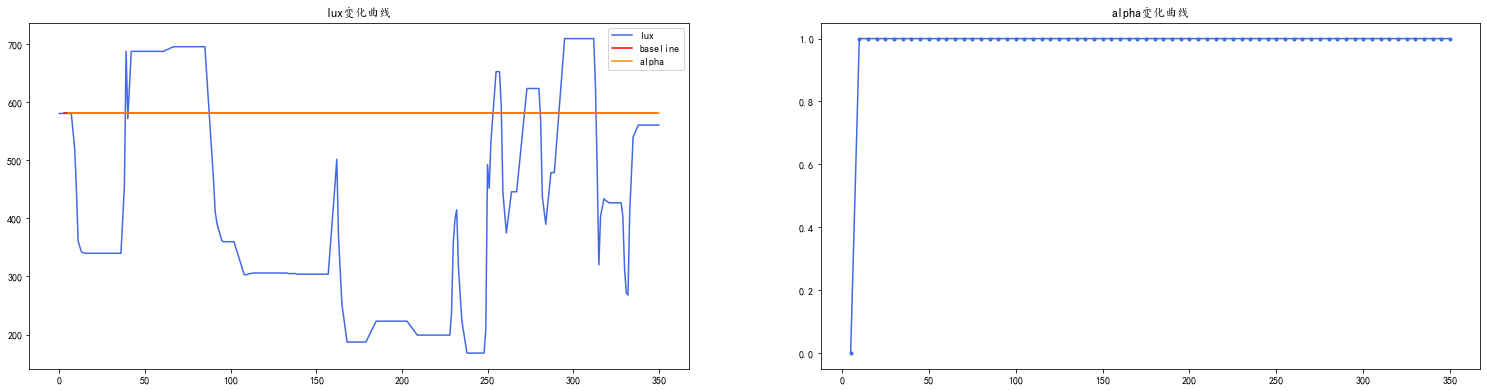

In [152]:
plt.figure(figsize = (26,14))
plt.rcParams['font.sans-serif'] = ['KaiTi']

s = [50,61,41,62,35,58,66,50,51,51,52,50,61,41,62,35,58,66,50,51,51,52,80,130,150,170,
    200,200,201,202,210,200,200,600,600,400,350,
    200,200,201,202,210,200,200,201,202,210,200,200,201,202,201,202,210,200,200,201,202] 

s = [50,61,61,62,60,60,66,60,65,61,62,60,60,66,60,65,60,60,66,60,65,61,62,1000,1000,1000,1000,61,41,62,35,58,66,50,51,51,52,58,66,50,51,51,52] 
s = [50,61,61,62,60,60,66,60,65,61,62,60,60,66,60,65,60,60,66,60,65,61,62,9999,61,41,62,35,58,66,50,51,51,52,58,66,50,51,51,52] 
s = [50,61,61,62,60,60,66,60,65,61,62,60,60,66,60,65,60,60,66,60,65,61,62,1000,1000,1000,1000,1100, 1050,1200,1200,1210,1130,1100,1050,1000] 

s = readFromRecord('room.txt')   # _special  # night daywalk daybike room cloudy record

# s = np.subtract(s, 8000)  #daywalk
# s = np.divide(s, 12)

# s = np.subtract(s, 7000)  #daybike
# s = np.where(s<0, 0, s)
# s = np.divide(s, 3)

# s = s[40:80]
mk = '.'
mk = None
col = 2
row = 2
plt.subplot(col,row,1)
plt.plot(s, c='royalblue', label='lux', marker=mk)

stable_list, res_idx, Gauss_list, gs_high, gs_low, mean_list, a_list, std_list = Gauss2(s, 0, 5, 'RMS') 
stable_list2, stable_idx = AIBrightness(s, need_small=False, always_usd_std=False)
# stable_list2, stable_idx, Gauss_list2, gs_high2, gs_low22, mean_list2, a_list2, std_list2 = Gauss2(s, 0, 5, 'RMS') 

mk = '.'
mk = None
if len(s) > 850:
    mk = None
plt.plot(stable_idx, stable_list2, marker=mk, c='r', label='baseline')
plt.plot(res_idx, stable_list, marker=mk, c='darkorange', label='alpha')
plt.title('lux变化曲线')  
plt.legend(loc='best')

mk = '.'
plt.subplot(col,row,2)
plt.plot(res_idx, a_list, marker=mk, c='royalblue')
plt.title('alpha变化曲线')  

# plt.subplot(3,2,3)
# plt.plot(res_idx[1:], Gauss_list, marker=mk)

# plt.subplot(3,2,3)
# plt.plot(res_idx, mean_list, marker=mk, c='r')
# plt.plot(res_idx[1:], gs_high, marker=mk)
# plt.plot(res_idx[1:], gs_low, marker=mk)

plt.show()

0.6065306597126334
0.1353352832366127


C:\codes\python\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\codes\python\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


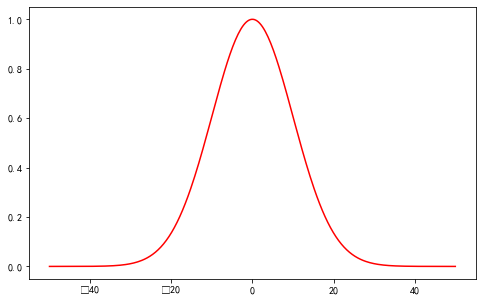

In [105]:
"""实现高斯分布函数
"""
def normalization(data):
    _range = np.max(data) - np.min(data)
    return (data - np.min(data)) / _range


def normal_distribution(x, mean, sigma):
    return np.exp(-1*((x-mean)**2)/(2*(sigma**2)))/(math.sqrt(2*np.pi)* sigma)

def norm_normal_distribution(x, mean, sigma):
    gs_max = normal_distribution(mean, mean, sigma)
    gs_cur = normal_distribution(x, mean, sigma)
    return gs_cur/gs_max


plt.rcParams['font.sans-serif'] = ['KaiTi']

#写了这个，就不需要plt.show()
x = np.linspace(-50, 50, 300)
### 代码开始 ### (≈ 5~10 行代码)
y_1 = norm_normal_distribution(x, 0, 10)
# y_2 = norm_normal_distribution(x, 3, 10)
print(norm_normal_distribution(10, 0, 10))

print(norm_normal_distribution(20, 0, 10))
plt.figure(figsize=(8,5))#控制画布的大小
plt.plot(x, y_1, c='r') #, label="u=0, d=1"
# plt.plot(x, y_2, c='g') #, label="u=0, d=1"

plt.show()

20 0 0
21 1 0
22 2 0
23 3 0
28 8 0
36 16 0
57.599999999999994 36 14.400000000000002
96.0 60 24.0
160.0 100 40.0
416.0 260 104.0
864.0 540 216.0
1600.0 1000 400.0
3600.0 2250 900.0
7360.0 4600 1840.0
9440.0 5900 2360.0
13760.0 8600 3440.0


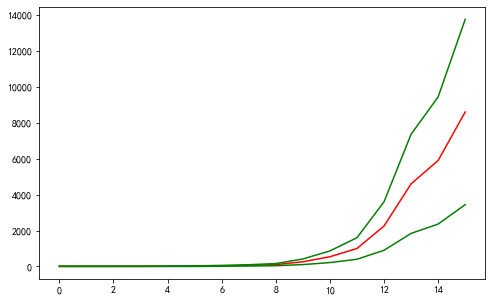

In [39]:
x = [0,1,2,3,8,16,36,60,100,260,540,1000,2250,4600,5900,8600]
plt.figure(figsize=(8,5))#控制画布的大小

low = []
high = []
for i in x:
    sigma =  max(i*0.3, 10)
    high.append(i+2*sigma)
    low.append(max(i-2*sigma, 0))
    print(i+2*sigma, i, max(i-2*sigma, 0))
# for i in x:
#     log_i = math.log(i+1)
#     sigma =  max(log_i*0.1, math.log(10))
#     high.append(math.exp(log_i+sigma))
#     low.append(max(math.exp(log_i-sigma), 0))
#     print(math.exp(log_i+sigma), math.exp(log_i), max(math.exp(log_i-sigma), 0))

plt.plot(x, c='r') #, label="u=0, d=1"
plt.plot(high, c='g') #, label="u=0, d=1"
plt.plot(low, c='g') #, label="u=0, d=1"

plt.show()

In [19]:
def weightMean(s_temp):
    weight = 1
    mean = 0.0
    all_weight = 0
    for i in s_temp:
        mean = mean + weight*i
        all_weight += weight
        weight += 1
    mean /= all_weight
    return mean

data = [100, 110, 3000, 3000, 90]
data = [100, 110, 3000, 90, 3000]

def cal(data):
    print('mean:', np.mean(data))
    print('RMS:', math.sqrt(np.sum(np.array(data)**2, dtype=float) / len(data))) 
    print('median:', np.median(data))
    print('weightMean:', weightMean(data))

    data.sort()
    print('mid mean:', np.mean(data[1:-1]))

cal([100, 110, 3000, 3000, 90])
print('\n')
cal( [100, 110, 150, 90, 3000])
print('\n')
cal( [100, 110, 200, 300, 450])
print('\n')
cal( [450, 300, 200, 110, 100])

mean: 1260.0
RMS: 1898.9576087948883
median: 110.0
weightMean: 1451.3333333333333
mid mean: 1070.0


mean: 690.0
RMS: 1345.5630791605424
median: 110.0
weightMean: 1075.3333333333333
mid mean: 120.0


mean: 232.0
RMS: 266.30809225406574
median: 200.0
weightMean: 291.3333333333333
mid mean: 203.33333333333334


mean: 232.0
RMS: 266.30809225406574
median: 200.0
weightMean: 172.66666666666666
mid mean: 203.33333333333334
